# embedding query

送金回数を国に移転
```
MATCH (from:Country)--(:Entity)<-[:ORIGINATOR]-(f:Filing)-[:BENEFITS]->(:Entity)--(to:Country)
MERGE (from)-[t:TRANSFERRED_COUNTRY_SEPARATE {file_id:f.id}]->(to)
SET t.begin = f.begin
```


国別、送金回数
```
MATCH (from:Country)--(:Entity)<-[:ORIGINATOR]-(f:Filing)-[:BENEFITS]->(:Entity)--(to:Country)
WITH from, to, count(f) as ct, round(sum(f.amount)) as sum
RETURN from.name, to.name, sum, ct ORDER BY ct DESC LIMIT 10
```

## ネットワーク作成

```
CALL gds.graph.create.cypher('epoch1', 
'MATCH (c:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-() WHERE r.begin.year < 2012
WITH DISTINCT c RETURN id(c) AS id',
'MATCH (c_from:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-(c_to) WHERE r.begin.year < 2012 WITH r, c_from, c_to RETURN id(c_from) AS source, id(c_to) AS target'
)
```

```
CALL gds.graph.create.cypher('epoch2', 
'MATCH (c:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-() WHERE r.begin.year >= 2012 AND r.begin.year < 2015 WITH DISTINCT c RETURN id(c) AS id',
'MATCH (c_from:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-(c_to) WHERE r.begin.year >= 2012 AND r.begin.year < 2015 WITH r, c_from, c_to RETURN id(c_from) AS source, id(c_to) AS target'
)
```

```
CALL gds.graph.create.cypher('epoch3', 
'MATCH (c:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-() WHERE r.begin.year >= 2015
WITH DISTINCT c RETURN id(c) AS id',
'MATCH (c_from:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-(c_to) WHERE r.begin.year >= 2015 WITH r, c_from, c_to RETURN id(c_from) AS source, id(c_to) AS target'
)
```

## Embedding

```
CALL gds.alpha.node2vec.write(
	'epoch1',
	{writeProperty: 'vector_epoch1', 
    embeddingSize: 3}
)
```

```
CALL gds.alpha.node2vec.write(
	'epoch2',
	{writeProperty: 'vector_epoch2', 
    embeddingSize: 3}
)
```

```
CALL gds.alpha.node2vec.write(
	'epoch3',
	{writeProperty: 'vector_epoch3', 
    embeddingSize: 3}
)
```

### 各Epochごとのノード

```
MATCH (c:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-()
WHERE r.begin.year < 2012
WITH DISTINCT c
RETURN count(c)
```

```
MATCH (c:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-()
WHERE r.begin.year >= 2012 AND r.begin.year < 2015
WITH DISTINCT c
RETURN count(c)
```

```
MATCH (c:Country)-[r:TRANSFERRED_COUNTRY_SEPARATE]-()
WHERE r.begin.year >= 2015
WITH DISTINCT c
RETURN count(c)
```

### 全Epochに現れるノード

```
MATCH (c:Country)
WHERE exists(c.vector_epoch1) AND exists(c.vector_epoch2) AND exists(c.vector_epoch3)
RETURN count(c)
```

各Epochごとの連結メンバー数
```
MATCH (c:Country) 
WITH c.country_connect_epoch2 AS community_id, count(c) as member_count 
WHERE member_count > 1
RETURN community_id, member_count 
ORDER BY member_count DESC
```

# Embedding

In [13]:
import plotly.express as px
import numpy as np

In [14]:
from neo4j import GraphDatabase
from tqdm.notebook import tqdm
import json

import pandas as pd

In [15]:
auth_path = './data/neo4j_graph/auth.json'
with open(auth_path, 'r') as f:
    auth = json.load(f)

# ローカルの場合は通常 uri: bolt(or neo4j)://localhost:7687, user: neo4j, pd: 設定したもの
# サンドボックスの場合は作成画面から接続情報が見られます
uri = 'neo4j://localhost:7687'
driver = GraphDatabase.driver(uri=uri, auth=(auth['user'], auth['pd']))

# Sandboxの場合はこんな感じ
# uri = 'bolt://54.175.38.249:35275'
# driver = GraphDatabase.driver(uri=uri, auth=('neo4j', 'spray-missile-sizing'))

In [16]:
with driver.session() as session:
    connected_community_res = session.run('''
    MATCH (c:Country) WHERE exists(c.vector_epoch1) RETURN c.name AS name, c.vector_epoch1 as vector, c.country_connect_epoch1 as community
    ''')

In [17]:
connected_community_res_df = pd.DataFrame([r.data() for r in connected_community_res])

In [18]:
connected_community_res_df

,name,vector,community
0,Angola,"[0.48045614361763, 0.47880592942237854, 0.9012...",5
1,Australia,"[0.9593270421028137, -0.07071617990732193, 0.8...",5
2,Austria,"[0.9999794960021973, 0.3390905261039734, 0.628...",5
3,Belarus,"[0.7945102453231812, 0.7835907340049744, 0.611...",5
4,Belgium,"[0.6601837277412415, 0.37783828377723694, 0.82...",5
...,...,...,...
75,United Kingdom,"[0.7704684138298035, 0.6284512877464294, 0.683...",5
76,United States,"[0.6865010857582092, 0.7116077542304993, 0.689...",5
77,Uruguay,"[0.3291316032409668, 0.49821245670318604, 1.20...",5
78,Vietnam,"[1.133726954460144, 1.024403691291809, 0.33852...",5


In [19]:
dim_no = len(connected_community_res_df['vector'].iloc[0])

In [20]:
def renorm_vector(v):
    norm = np.sqrt(sum([c**2 for c in v]))
    return np.array(v) / norm

In [21]:
ax_columns = ['x{}'.format(i) for i in range(1, dim_no+1)]

# res_df[ax_columns] = res_df.embedding.apply(pd.Series)

connected_community_res_df[ax_columns] = connected_community_res_df.vector.apply(lambda x: pd.Series(renorm_vector(x)))
# connected_community_res_df[ax_columns] = connected_community_res_df.vector.apply(lambda x: pd.Series(x))

In [22]:
connected_community_res_df

,name,vector,community,x1,x2,x3
0,Angola,"[0.48045614361763, 0.47880592942237854, 0.9012...",5,0.425942,0.424479,0.798993
1,Australia,"[0.9593270421028137, -0.07071617990732193, 0.8...",5,0.757498,-0.055838,0.650446
2,Austria,"[0.9999794960021973, 0.3390905261039734, 0.628...",5,0.813717,0.275929,0.511593
3,Belarus,"[0.7945102453231812, 0.7835907340049744, 0.611...",5,0.624384,0.615803,0.480553
4,Belgium,"[0.6601837277412415, 0.37783828377723694, 0.82...",5,0.589433,0.337346,0.734007
...,...,...,...,...,...,...
75,United Kingdom,"[0.7704684138298035, 0.6284512877464294, 0.683...",5,0.638622,0.520908,0.566407
76,United States,"[0.6865010857582092, 0.7116077542304993, 0.689...",5,0.569498,0.590326,0.572003
77,Uruguay,"[0.3291316032409668, 0.49821245670318604, 1.20...",5,0.245123,0.371047,0.895678
78,Vietnam,"[1.133726954460144, 1.024403691291809, 0.33852...",5,0.724410,0.654556,0.216302


In [31]:
connected_community_res_df['color'] = (connected_community_res_df['name'] == 'Singapore').apply(lambda x: {True: 'r', False:'b'}[x])
connected_community_res_df['color'] = (connected_community_res_df['name'] == 'Singapore').apply(lambda x: {True: 'r', False:'b'}[x])

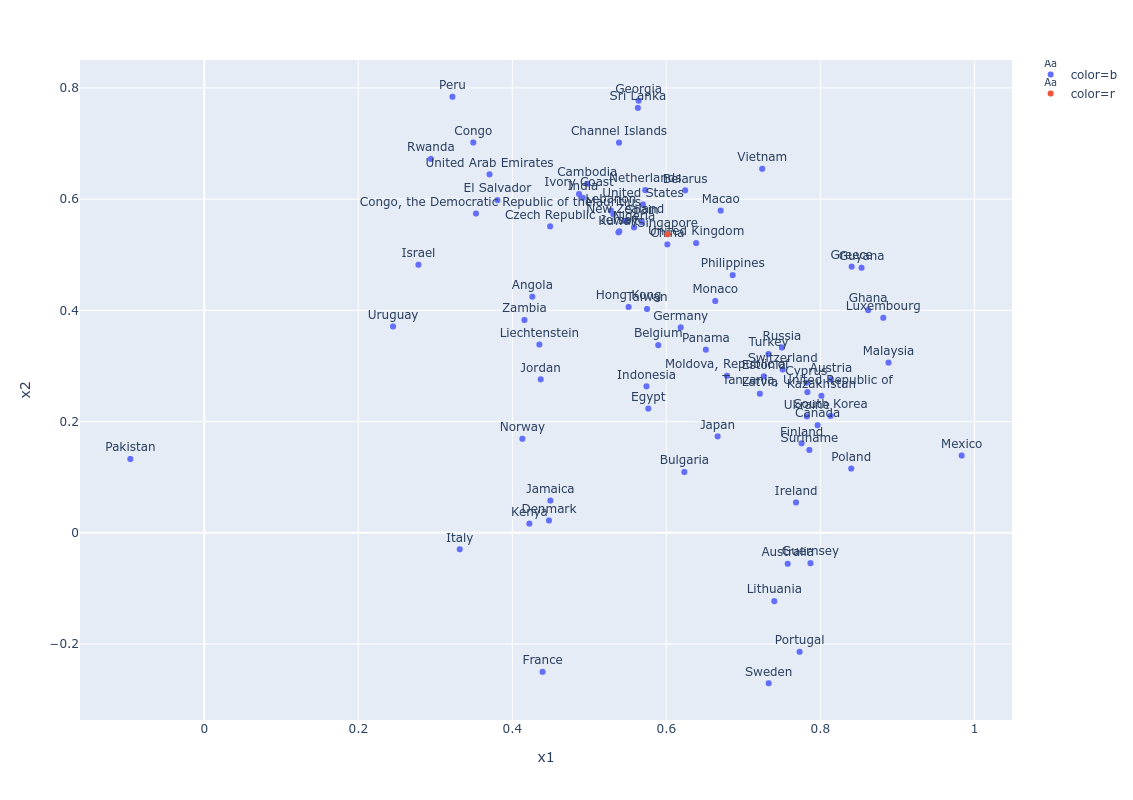

In [32]:
fig = px.scatter(connected_community_res_df,  
                    x="x1",  
                    y="x2",   
                    text="name",  
                    color='color',  
                    log_x=False,  
                    size_max=60)

fig.update_traces(textposition='top center')

fig.update_layout(
    height=800,
    title_text=''
)

fig.show()

In [28]:
connected_community_res_df[connected_community_res_df['name'] == 'Singapore']

,name,vector,community,x1,x2,x3,color
64,Singapore,"[0.7193834185600281, 0.6419739127159119, 0.707...",5,0.601544,0.536814,0.591587,True


# eda

In [12]:
with driver.session() as session:
    res = session.run('''
    MATCH (c:Country {name: $name})<-[r]-(c_to:Country) 
    RETURN c.name AS name, r.amount AS amount, type(r) AS type, c_to.name AS name_from ORDER BY r.amount DESC
    ''', name='Singapore')

In [37]:
res_df = pd.DataFrame([r.data() for r in res])

In [38]:
res_df

,name,amount,type,name_from
0,Singapore,150000000.0,TRANSFERRED_COUNTRY_EPOCH2,Russia
1,Singapore,73534360.0,TRANSFERRED_COUNTRY_EPOCH2,Monaco
2,Singapore,48443923.0,TRANSFERRED_COUNTRY_EPOCH3,Australia
3,Singapore,33067731.0,TRANSFERRED_COUNTRY_EPOCH1,Liechtenstein
4,Singapore,25500000.0,TRANSFERRED_COUNTRY_EPOCH3,Panama
...,...,...,...,...
73,Singapore,50000.0,TRANSFERRED_COUNTRY_EPOCH1,Cambodia
74,Singapore,6695.0,TRANSFERRED_COUNTRY_EPOCH1,Sri Lanka
75,Singapore,5657.0,TRANSFERRED_COUNTRY_EPOCH1,Germany
76,Singapore,3595.0,TRANSFERRED_COUNTRY_EPOCH1,Czech Republic


In [40]:
pivot_df = res_df.groupby(['type', 'name_from']).mean()

In [41]:
pivot_df

amount
type                       name_from                       
TRANSFERRED_COUNTRY_EPOCH1 Cambodia                 50000.0
                           China                   815684.0
                           Cyprus                  210000.0
                           Czech Republic            3595.0
                           Estonia                 148089.0
...                                                     ...
TRANSFERRED_COUNTRY_EPOCH3 Thailand              22300000.0
                           United Arab Emirates   8100000.0
                           United Kingdom         1739599.0
                           United States           352417.0
                           Vietnam                6200000.0

[78 rows x 1 columns]

In [42]:
pivot_df.sort_values('amount', ascending=False).iloc[:10]

amount
type                       name_from                 
TRANSFERRED_COUNTRY_EPOCH2 Russia         150000000.0
                           Monaco          73534360.0
TRANSFERRED_COUNTRY_EPOCH3 Australia       48443923.0
TRANSFERRED_COUNTRY_EPOCH1 Liechtenstein   33067731.0
TRANSFERRED_COUNTRY_EPOCH3 Panama          25500000.0
                           Thailand        22300000.0
TRANSFERRED_COUNTRY_EPOCH1 Switzerland     15000000.0
                           Monaco          11500000.0
TRANSFERRED_COUNTRY_EPOCH3 Indonesia       10212877.0
TRANSFERRED_COUNTRY_EPOCH2 Thailand         9450000.0

In [27]:
type(pivot_df)

pandas.core.frame.DataFrame

In [28]:
pivot_df.index

MultiIndex([('TRANSFERRED_COUNTRY_EPOCH1',              'Austria'),
            ('TRANSFERRED_COUNTRY_EPOCH1',              'Belgium'),
            ('TRANSFERRED_COUNTRY_EPOCH1',             'Cambodia'),
            ('TRANSFERRED_COUNTRY_EPOCH1',      'Channel Islands'),
            ('TRANSFERRED_COUNTRY_EPOCH1',                'China'),
            ('TRANSFERRED_COUNTRY_EPOCH1',               'Cyprus'),
            ('TRANSFERRED_COUNTRY_EPOCH1',       'Czech Republic'),
            ('TRANSFERRED_COUNTRY_EPOCH1',              'Estonia'),
            ('TRANSFERRED_COUNTRY_EPOCH1',              'Germany'),
            ('TRANSFERRED_COUNTRY_EPOCH1',            'Hong Kong'),
            ...
            ('TRANSFERRED_COUNTRY_EPOCH3',           'Seychelles'),
            ('TRANSFERRED_COUNTRY_EPOCH3',            'Singapore'),
            ('TRANSFERRED_COUNTRY_EPOCH3',          'Switzerland'),
            ('TRANSFERRED_COUNTRY_EPOCH3',               'Taiwan'),
            ('TRANSFERRED_COUNTR

In [47]:
res_df.type.value_counts()

TRANSFERRED_COUNTRY_EPOCH2    32
TRANSFERRED_COUNTRY_EPOCH1    24
TRANSFERRED_COUNTRY_EPOCH3    22
Name: type, dtype: int64

In [51]:
type_list = list(res_df.type.value_counts().index)
type_list.sort()

In [56]:
epoch_df_list = []
for t in type_list:
    epoch_df_list.append(res_df[res_df.type == t].sort_values('amount', ascending=False))

In [59]:
epoch_df_list[0]

,name,amount,type,name_from
3,Singapore,33067731.0,TRANSFERRED_COUNTRY_EPOCH1,Liechtenstein
6,Singapore,15000000.0,TRANSFERRED_COUNTRY_EPOCH1,Switzerland
7,Singapore,11500000.0,TRANSFERRED_COUNTRY_EPOCH1,Monaco
10,Singapore,9391000.0,TRANSFERRED_COUNTRY_EPOCH1,Israel
11,Singapore,8698041.0,TRANSFERRED_COUNTRY_EPOCH1,"Tanzania, United Republic of"
40,Singapore,2120000.0,TRANSFERRED_COUNTRY_EPOCH1,Latvia
42,Singapore,1842384.0,TRANSFERRED_COUNTRY_EPOCH1,Philippines
49,Singapore,815684.0,TRANSFERRED_COUNTRY_EPOCH1,China
63,Singapore,384949.0,TRANSFERRED_COUNTRY_EPOCH1,Singapore
62,Singapore,384949.0,TRANSFERRED_COUNTRY_EPOCH1,United States


In [60]:
epoch_df_list[1]

,name,amount,type,name_from
0,Singapore,150000000.0,TRANSFERRED_COUNTRY_EPOCH2,Russia
1,Singapore,73534360.0,TRANSFERRED_COUNTRY_EPOCH2,Monaco
9,Singapore,9450000.0,TRANSFERRED_COUNTRY_EPOCH2,Thailand
12,Singapore,8585000.0,TRANSFERRED_COUNTRY_EPOCH2,"Moldova, Republic of"
13,Singapore,8499977.0,TRANSFERRED_COUNTRY_EPOCH2,Saudi Arabia
18,Singapore,7464817.0,TRANSFERRED_COUNTRY_EPOCH2,Cyprus
24,Singapore,4473076.0,TRANSFERRED_COUNTRY_EPOCH2,Germany
25,Singapore,4473076.0,TRANSFERRED_COUNTRY_EPOCH2,United States
26,Singapore,4473076.0,TRANSFERRED_COUNTRY_EPOCH2,United Kingdom
27,Singapore,4473076.0,TRANSFERRED_COUNTRY_EPOCH2,India


In [61]:
epoch_df_list[2]

,name,amount,type,name_from
2,Singapore,48443923.0,TRANSFERRED_COUNTRY_EPOCH3,Australia
4,Singapore,25500000.0,TRANSFERRED_COUNTRY_EPOCH3,Panama
5,Singapore,22300000.0,TRANSFERRED_COUNTRY_EPOCH3,Thailand
8,Singapore,10212877.0,TRANSFERRED_COUNTRY_EPOCH3,Indonesia
14,Singapore,8100000.0,TRANSFERRED_COUNTRY_EPOCH3,Cyprus
15,Singapore,8100000.0,TRANSFERRED_COUNTRY_EPOCH3,Seychelles
16,Singapore,8100000.0,TRANSFERRED_COUNTRY_EPOCH3,United Arab Emirates
17,Singapore,8100000.0,TRANSFERRED_COUNTRY_EPOCH3,Switzerland
19,Singapore,6750000.0,TRANSFERRED_COUNTRY_EPOCH3,Germany
20,Singapore,6750000.0,TRANSFERRED_COUNTRY_EPOCH3,Belgium


# backup

国間の送金ネット

```
MATCH (from:Country)--(:Entity)<-[:ORIGINATOR]-(f:Filing)-[:BENEFITS]->(:Entity)--(to:Country)
WITH from, to, round(sum(f.amount)) as sum
MERGE (from)-[t:TRANSFERRED_COUNTRY]->(to) SET t.amount = sum
```

連結成分の確認

```
CALL gds.wcc.write({
  nodeProjection: 'Country',
  relationshipProjection: {
    relType: {type: 'TRANSFERRED_COUNTRY', orientation: 'UNDIRECTED'
    }
  }, writeProperty: 'country_comunity'
});
```

EPOCHのリンク

```
MATCH (from:Country)--(:Entity)<-[:ORIGINATOR]-(f:Filing)-[:BENEFITS]->(:Entity)--(to:Country)
WHERE f.begin.year < 2012
WITH from, to, round(sum(f.amount)) as sum
MERGE (from)-[t:TRANSFERRED_COUNTRY_EPOCH1]->(to) SET t.amount = sum
```

```
MATCH (from:Country)--(:Entity)<-[:ORIGINATOR]-(f:Filing)-[:BENEFITS]->(:Entity)--(to:Country)
WHERE f.begin.year >= 2012 AND f.begin.year < 2015
WITH from, to, round(sum(f.amount)) as sum
MERGE (from)-[t:TRANSFERRED_COUNTRY_EPOCH2]->(to) SET t.amount = sum
```

```
MATCH (from:Country)--(:Entity)<-[:ORIGINATOR]-(f:Filing)-[:BENEFITS]->(:Entity)--(to:Country)
WHERE f.begin.year >= 2015
WITH from, to, round(sum(f.amount)) as sum
MERGE (from)-[t:TRANSFERRED_COUNTRY_EPOCH3]->(to) SET t.amount = sum
```

Filingの国調査

```
MATCH (from:Country)--(:Entity)<-[:ORIGINATOR]-(f:Filing)-[:BENEFITS]->(:Entity)--(to:Country)
WHERE f.begin.year > 2011 AND f.begin.year < 2015
WITH DISTINCT f, from, to, round(sum(f.amount)) as sum
RETURN f.id, sum ORDER BY sum DESC LIMIT 10
```

```
MATCH (from:Country)--(:Entity)-[:ORIGINATOR]-(f:Filing)-[:BENEFITS]-(:Entity)--(to:Country) 
WITH f, count(from)+count(to) as ct 
RETURN f.id, ct ORDER BY ct DESC
```

連結成分

```
CALL gds.wcc.write({
  nodeProjection: 'Country',
  relationshipProjection: {
    relType: {type: 'TRANSFERRED_COUNTRY_EPOCH1', orientation: 'UNDIRECTED'
    }
  }, writeProperty: 'country_connect_epoch1'
});
```

```
CALL gds.wcc.write({
  nodeProjection: 'Country',
  relationshipProjection: {
    relType: {type: 'TRANSFERRED_COUNTRY_EPOCH2', orientation: 'UNDIRECTED'
    }
  }, writeProperty: 'country_connect_epoch2'
});
```

```
CALL gds.wcc.write({
  nodeProjection: 'Country',
  relationshipProjection: {
    relType: {type: 'TRANSFERRED_COUNTRY_EPOCH3', orientation: 'UNDIRECTED'
    }
  }, writeProperty: 'country_connect_epoch3'
});
```